In [158]:
import numpy as np
import pyedflib

import pandas as pd
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, ForgetDimension
from sklearn.model_selection import train_test_split, KFold
import random

# Choose EEG or EMG

In [159]:
# Choose if you want to look at EEG or EMG data

data_type = "EEG" # Does not have an effect yet, will be added later when processing anesthesia data
#data_type = "EMG"

In [160]:
subject = "298"


In [161]:
label_list = [1, 2, 3, 4, 5, 7]


# Import Data

In [162]:
# EEG/EMG data

def read_edf_file(file_path):
    """
    Reads an .edf file and returns the EEG and EMG streams as pandas DataFrames.
    """
    f = pyedflib.EdfReader(file_path)

    # Assuming the EEG channel is the first channel and EMG is the second channel
    eeg_signal = f.readSignal(0)
    emg_signal = f.readSignal(1)

    # Extract the channel names for the DataFrame
    eeg_channel_name = f.getSignalLabels()[0]
    emg_channel_name = f.getSignalLabels()[1]

    # Get the sample frequency
    sample_frequency = f.getSampleFrequency(0)  # Assuming both streams have the same frequency

    # Calculate the timestamps for the samples
    n_samples = min(len(eeg_signal), len(emg_signal))
    time = [i / sample_frequency for i in range(n_samples)]

    # Create pandas DataFrame
    df = pd.DataFrame({
        'Time': time,
        eeg_channel_name: eeg_signal[:n_samples],
        emg_channel_name: emg_signal[:n_samples],
    })

    # Close the EdfReader
    f.close()

    return df


# Read file
#file = 'Data/edf_293.edf'

# Convert to pandas DataFrame
#data = read_edf_file(file)
#data.to_csv("Data/EDF_as_CSV_"+str(subject)+"_complete.csv")


In [163]:
# Labels

# Read data
label_data = pd.read_csv("Data/Labels_"+str(subject)+".csv")
labels = label_data["NAPS_Numeric"].iloc[1:] # The first label is NaN, so remove it

# Convert to list
labels = [int(label) for label in labels]


In [164]:
# EEG & EMG data

data = pd.read_csv("Data/EDF_as_CSV_"+str(subject)+"_complete.csv")

In [165]:
def preprocess_data(data, labels):

    data = data.iloc[2000:] # The first label is NaN... Therefore we have to remove the first 2000 values corresponding to the first label

    data.reset_index(drop=True, inplace=True)

    # Add labels to the main dataframe and Assign labels to data rows in segments 
    data['Label'] = np.nan
    
    for label_idx in range(len(labels) - 1):
        data.loc[2000 * label_idx : 2000 * (label_idx + 1) - 1, 'Label'] = labels[label_idx]
        
    # Drop rows where 'Label' is NaN
    data.dropna(subset=['Label'], inplace=True)

    # Drop columns containing 'Unnamed' in their column name
    columns_to_drop = data.filter(like='Unnamed').columns
    data.drop(columns=columns_to_drop, inplace=True)


    return data


In [166]:
data = preprocess_data(data, labels)

/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_75471/316733124.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Label'] = np.nan
/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_75471/316733124.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['Label'], inplace=True)
/var/folders/f_/tyg450s17m53dh3ylrjcmpqc0000gn/T/ipykernel_75471/316733124.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

# Preprocessing

## Segmenting Data

In [167]:
def segment_data(df, data_type, segment_size, step_size = 2):
    """
    Segments time-series data into EEG and EMG segments.

    Parameters:
    - df (DataFrame): The input dataframe containing the columns "Time", "EEG" and "EMG".
    - segment_size (float): The desired size of each segment in seconds.
    - step_size (float, optional): The step size of "Time" in milliseconds. Default is 2 millisecond.

    Returns:
    Tuple of two lists:
    - List of EEG segments.
    - List of EMG segments.
    """

    df.reset_index(inplace=True)

    n_segments = int((len(df.index))*step_size) // segment_size // 1000
    segments = []

    for segment_idx in range(n_segments):
        start_idx = int(segment_idx* segment_size*1000/step_size)
        end_idx = start_idx + int(segment_size*1000/step_size)
        segment = df[data_type].iloc[start_idx:end_idx]
        segments.append(list(segment))

    return segments

In [168]:
# Segment the datass
segment_size = 4  # seconds

segments = {}

for label in label_list:
    segments[label] = segment_data(data[data['Label'] == label], data_type, segment_size)

In [152]:
def return_list_with_all_segments(segments, label_list):

    all_segments = list()
    
    for label in label_list:
        all_segments.extend(segments[label])

    return all_segments


all_segments = return_list_with_all_segments(segments, label_list)

## Remove outliers

Plot data with outliers

In [172]:
def return_flattened_segments(segments, label_list):

    all_segments = {1: [], 2: [], 3: [], 4: [], 5: [], 7: []}
    
    for label in label_list:
        for sgmt in segments[label]:
            all_segments[label].extend(sgmt)

    return all_segments


flattened_segments = return_flattened_segments(segments, label_list)

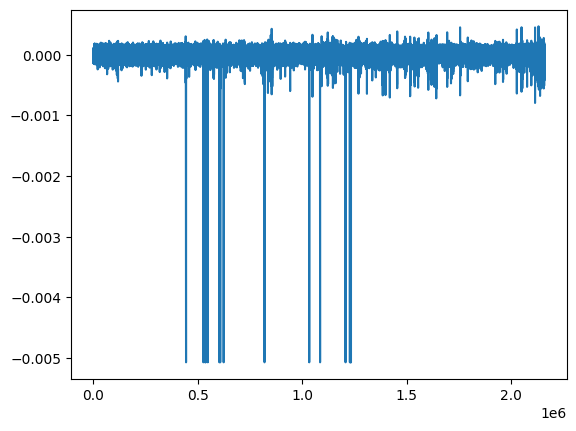

In [181]:
import matplotlib.pyplot as plt

plt.plot(flattened_segments[1])

In [187]:
def detect_artifacts(segments_of_our_label, all_segments, threshold):
    
    # Calculate the mean and standard deviation of the maximum absolute value in each segment
    # of all time series

    all_mav = []  # maximal absolute values of all segments
    
    for segment in all_segments:
        all_mav.append(np.max(np.abs(segment)))

    mean = np.mean(all_mav)
    std = np.std(all_mav)

    mav_of_our_label = [] # maximal absolute values of all segments of our labels
    
    for segment in segments_of_our_label:
        mav_of_our_label.append(np.max(np.abs(segment)))
    
    # Calculate the Z-scores for each data point
    z_scores = (mav_of_our_label - mean) / std
          
    # Find data points with Z-scores above the threshold (outliers)
    outliers_indices = np.where(np.abs(z_scores) > threshold)[0]

    print("Indices of outliers: " +str(outliers_indices))

    return outliers_indices


outlier_indices = {}

for label in [1, 2, 3, 4, 5]:
    outlier_indices[label] = detect_artifacts(segments[label], all_segments, threshold=4)

Indices of outliers: [221 263 267 268 273 301 303 311 409 516 542 603 614 616]
Indices of outliers: []
Indices of outliers: []
Indices of outliers: []
Indices of outliers: []


In [188]:
def relabel_segments(label_list, segments, outlier_indices):

    # Save the segments of each label for finding outliers

    new_segments = {} # Addionally 
    new_segments[7] = segments[7]

    for label in [1, 2, 3, 4, 5]:
        new_segments[label] = [segment for idx, segment in enumerate(segments[label]) if idx not in outlier_indices[label]]
        segments_to_append_to_label_7 = [segment for idx, segment in enumerate(segments[label]) if idx in outlier_indices[label]]
        new_segments[7].append(segments_to_append_to_label_7)
    
    return new_segments

new_segments = relabel_segments(label_list, segments, outlier_indices)

Plots data without outliers

In [189]:
flattened_segments = return_flattened_segments(new_segments, label_list)

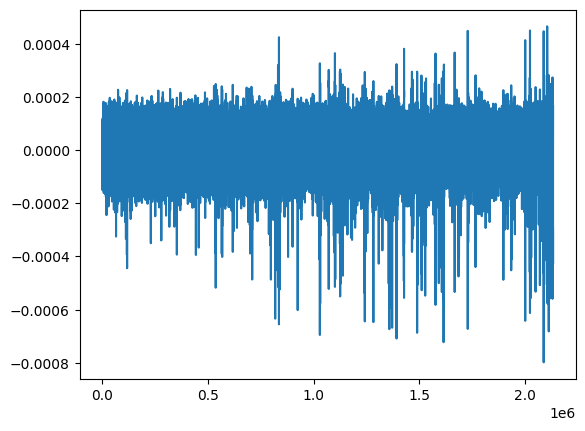

In [190]:
import matplotlib.pyplot as plt

plt.plot(flattened_segments[1])


All outliers were removed :).

# Compute Indices for Cross Validation and Final Test Set

In [191]:
# Choose test data set size for classification later (recommended: 0.2-0.3)

test_size = 0.2

In [192]:
# Choose number of folds for Cross Validation of the training/validation data

n_folds = 5

### Choose Train and Test Data Indices for Test Set and for Each Fold

In [193]:
def choose_train_and_test_indices(segments, test_size):
    train_indices_dict = {}
    test_indices_dict = {}

    # Iterate through each label and perform train/test split
    for label, segments_values in segments.items():


        # Perform train/test split
        train_indices, test_indices = train_test_split(np.arange(len(segments_values)), test_size=test_size, random_state=32)


        # Store the split indices
        train_indices_dict["Label_"+str(label)] = train_indices
        test_indices_dict["Label_"+str(label)] = test_indices


    return train_indices_dict, test_indices_dict


# Choose train and test indices
train_indices_dict, test_indices_dict = choose_train_and_test_indices(segments, test_size)

In [194]:
def compute_train_and_validation_set_indices_for_cross_validation(label_list, segments, train_indices_dict, n_folds):
    
    # Initialize Cross Validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    train_indices_dict_for_folds = {}
    validation_indices_dict_for_folds = {}
    
    for label in label_list:
        label_key = "Label_" + str(label)
        
        # Initialize dictionary for each label
        train_indices_dict_for_folds[label_key] = {}
        validation_indices_dict_for_folds[label_key] = {}
        
        label_indices = train_indices_dict[label_key]
        
        # Use KFold only if there are enough samples for cross-validation
        if len(label_indices) >= 5:
            for fold, (train_indices, validation_indices) in enumerate(kf.split(label_indices)):
                train_indices_dict_for_folds[label_key][f"Fold_{fold}"] = label_indices[train_indices]
                validation_indices_dict_for_folds[label_key][f"Fold_{fold}"] = label_indices[validation_indices]
        else:
            # Handle case where fewer than 5 samples are available
            for fold in range(len(label_indices)):
                train_indices_dict_for_folds[label_key][f"Fold_{fold}"] = [label_indices[fold]]
                validation_indices_dict_for_folds[label_key][f"Fold_{fold}"] = [label_indices[fold]]

            # Fill in remaining folds with empty lists if needed
            for remaining_fold in range(len(label_indices), n_folds):
                train_indices_dict_for_folds[label_key][f"Fold_{remaining_fold}"] = []
                validation_indices_dict_for_folds[label_key][f"Fold_{remaining_fold}"] = []
    
    return train_indices_dict_for_folds, validation_indices_dict_for_folds


train_indices_dict_for_folds, validation_indices_dict_for_folds = compute_train_and_validation_set_indices_for_cross_validation(label_list,
                                                                                    segments, train_indices_dict, n_folds)

In [195]:
# Save all indices

# Train indices
np.save("Train_Test_Splitting/"+str(subject)+"/Train_Indices_All_Labels_All_Folds.npy",\
    np.array(train_indices_dict_for_folds, dtype=object), allow_pickle=True)

# Validation indices
np.save("Train_Test_Splitting/"+str(subject)+"/Validation_Indices_All_Labels_All_Folds.npy",\
    np.array(validation_indices_dict_for_folds, dtype=object), allow_pickle=True)

# Final Test set indices
np.save("Train_Test_Splitting/"+str(subject)+"/Final_Test_Set_Indices_All_Labels.npy",\
    np.array(test_indices_dict, dtype=object), allow_pickle=True)



# Outliers

# Persistence Diagrams

## Finding the optimal embedding dimension and time delay

There are two techniques that can be used to determine these parameters automatically:
- Mutual information to determine the time delay
- False nearest neighbours to determine the embedding dimension

In [196]:
# Initialise the embedding
max_embedding_dimension = 30
max_time_delay = 30
stride = 10

embedder = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)

In [197]:
def find_optimal_parameters(embedder, segments, max_index, iterations = 8):
    """
    Finds (approximate) optimal embedding parameters by averaging optimal parameters of random segments.

    Parameters:
    - embedder (object): defined by SingleTakensEmbedding() or similar
    - segments (list of lists): Complete EEG/EMG segments
    - max_index (int): How many segments there are
    - iteratiors (int): How many random indices to sample

    Returns:
    Tuple of two floats:
    - Average optimal embedding dimension
    - Average optimal time delay
    """


    optimal_embeddings_dimensions = []
    optimal_time_delays = []
    
    for _ in range(iterations):
        random_index = random.randint(0, max_index)
        embedding = embedder.fit_transform(segments[random_index])
        
         # append optimal embedding dimension for this segment
        optimal_embeddings_dimensions.append(embedder.dimension_)

        # append optimal time delay for this segment
        optimal_time_delays.append(embedder.time_delay_)

        print("The optimal embedding dimension is " + str(np.mean(optimal_embeddings_dimensions)) + 
              " and the optimal time delay is " + str(np.mean(optimal_time_delays)))
        
        return int(np.mean(optimal_embeddings_dimensions)), int(np.mean(optimal_time_delays))

In [198]:
# Compute optimal embedding parameters
    
embedding_dimension, embedding_time_delay = find_optimal_parameters(embedder, all_segments, len(all_segments), iterations = 8)

The optimal embedding dimension is 5.0 and the optimal time delay is 21.0


## Creating Persistence Diagrams

In [199]:
# Setting parameters for point cloud embeddings

#embedding_dimension= 3 # for data exploration

embedder = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay, # computed above
    dimension=embedding_dimension, # computed above
    stride=stride,
)

In [200]:
# We will look at 0, 1 and 2 dimensional holes
homology_dimensions = [0, 1, 2]

# We will use a Vietoris Rips filtrations
persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)

### Computing Points Clouds and Persistence Diagrams

In [201]:
def compute_embeddings_and_diagrams(segments, time_delay_embeddings, persistence_diagrams, label):

    time_delay_embeddings["Label_"+str(label)] = []
    persistence_diagrams["Label_"+str(label)] = []

    # Compute embeddings and diagrams for the complete data
    for diagram_idx in range(len(segments[label])):
        time_delay_embeddings["Label_"+str(label)].append(embedder.fit_transform(segments[label][diagram_idx])[None, :, :])
        persistence_diagrams["Label_"+str(label)].append(persistence.fit_transform(time_delay_embeddings["Label_"+str(label)][diagram_idx]))
    
    return time_delay_embeddings, persistence_diagrams

In [ ]:
# Compute embeddings and persistence diagrams for the complete data

time_delay_embeddings = {}
persistence_diagrams = {}

for label in label_list:
    time_delay_embeddings, persistence_diagrams = compute_embeddings_and_diagrams(segments, time_delay_embeddings, persistence_diagrams, label)

## Save persistence diagrams and embeddings

In [ ]:
# Persistence diagrams
np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Persistence_Diagrams_All_Labels.npy', \
            np.array(persistence_diagrams, dtype=object), allow_pickle=True)

# Embeddings
np.save('Embeddings_and_Persistence_Diagrams/'+str(subject)+'/'+str(data_type)+'/Embeddings_All_Labels'+\
            '_Embedding_Dim'+str(embedding_dimension)+'.npy', np.array(time_delay_embeddings, dtype=object), allow_pickle=True)